In [1]:
import matplotlib.pyplot as plt
import random
import time
import itertools
import urllib
import math
import csv
import functools
from statistics import mean, stdev
import pandas as pd

In [2]:
def distance(A, B): 
    "The distance between two points."
    return math.sqrt((B[0] - A[0])**2 + (B[1] - A[1])**2)

def Cities(n, width=900, height=600, seed=42):
    "Make a set of n cities, each with random coordinates within a (width x height) rectangle."
    random.seed(seed * n)
    return frozenset((random.randrange(width), random.randrange(height))
                     for c in range(n))

def tour_length(tour):
    "The total of distances between each pair of consecutive cities in the tour."
    return sum(distance(tour[i], tour[i-1]) 
               for i in range(len(tour)))

In [3]:
def plot_tour(tour): 
    "Plot the cities as circles and the tour as lines between them."
    start = tour[0]
    plot_lines(list(tour) + [tour[0]])
    plot_lines([start], 'rs')
    
def plot_lines(points, style='bo-'):
    "Plot lines to connect a series of points."
    plt.plot([x for (x,y) in points], [y for (x,y) in points], style)
    plt.axis('scaled'); plt.axis('off')

def plot_tsp(algorithm,cities):
    tour = algorithm(cities)
    time.process_time()
    assert valid_tour(tour, cities)
    plot_tour(tour)
    plt.show()
    t = time.process_time()
    print("{} city tour with length {:.1f} in {:.3f} secs for {}"
          .format(len(tour), tour_length(tour), t, algorithm.__name__))
          
def valid_tour(tour,cities):
    return set(tour) == set(cities) and len(tour) == len(cities)

In [9]:
global_cities = Cities(40)

# Nearest Neighbor Algorithm

## No Strategy

In [4]:
def first(collection):
    return next(iter(collection))

def nearest_neighbor(A, cities):
    "Find the city in cities that is nearest to city A."
    return min(cities, key=lambda x: distance(x, A))

def nn_tsp(cities):
    """Start the tour at the first city; at each step extend the tour 
    by moving from the previous city to the nearest neighboring city, C,
    that has not yet been visited."""
    start = first(cities)
    tour = [start]
    unvisited = set(cities) - {start}
    while unvisited:
        c = nearest_neighbor(tour[-1],unvisited)
        tour.append(c)
        unvisited.remove(c)
    return tour

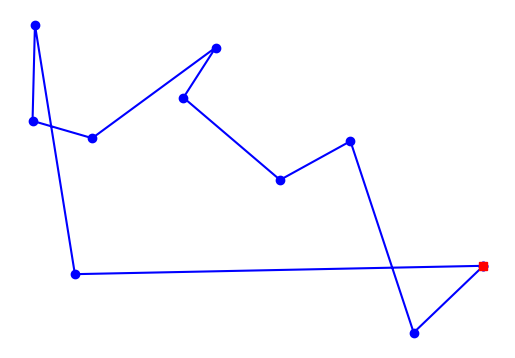

10 city tour with length 2577.9 in 5.812 secs for nn_tsp


In [8]:
plot_tsp(nn_tsp, global_cities)

## Repeated Strategy

Repetition Strategy: Take some algorithm and re-run it multiple times, varying some aspect each time, and take the solution with the best score

In [9]:
def nn_tsp(cities,start = None):
    """Start the tour at the first ; at each step extend the tour 
    by moving from the previous city to the nearest neighboring city, C,
    that has not yet been visited."""
    if start is None:
        start = first(cities)
    tour = [start]
    unvisited = set(cities) - {start}
    while unvisited:
        c = nearest_neighbor(tour[-1],unvisited)
        tour.append(c)
        unvisited.remove(c)
    return tour

def repeated_nn_tsp(cities):
    min_tour = min([nn_tsp(cities,start) for start in cities], key=tour_length)
    return min_tour

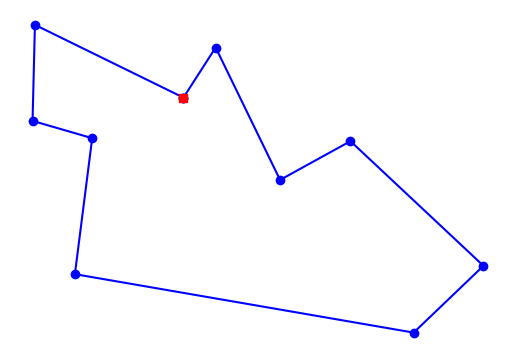

10 city tour with length 2297.7 in 5.891 secs for repeated_nn_tsp


In [10]:
plot_tsp(repeated_nn_tsp,global_cities)

## Random sample Strategy

Draw a random sample to decide which is the start city rather than iterating all the cities

In [233]:
def nn_tsp(cities,start = None):
    """Start the tour at the first city; at each step extend the tour 
    by moving from the previous city to the nearest neighboring city, C,
    that has not yet been visited."""
    if start is None:
        start = first(cities)
    tour = [start]
    unvisited = set(cities) - {start}
    while unvisited:
        c = nearest_neighbor(tour[-1],unvisited)
        tour.append(c)
        unvisited.remove(c)
    return tour

def random_repeated_nn_tsp(cities,n):
    min_tour = min([nn_tsp(cities,start) for start in random_cities(cities,n)], key=tour_length)
    return min_tour

def random_cities(cities,n):
    return_cities = set()
    cities = list(cities)
    for i in range(n):
        c = random.choice(cities)
        return_cities.add(c)
        cities.remove(c)
    return return_cities

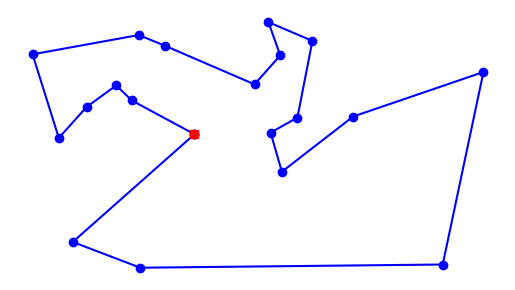

20 city tour with length 3218.8 in 3.734 secs for random_3_nn_tsp


In [245]:
def random_3_nn_tsp(cities):
    return random_repeated_nn_tsp(cities,3)
plot_tsp(random_3_nn_tsp,global_cities)

## Alteration Strategy

Introducing "Segements": \
We'll define a *segment* as a subsequence of a tour: a sequence of consecutive cities within a tour. A tour forms a loop, but a segment does not have a loop; it is open-ended on both ends. So, if `[A, B, C, D]` is a 4-city tour, then segments include `[A, B]`, `[B, C, D]`, and many others.  Note that the segment `[A, B, C, D]` is different than the tour `[A, B, C, D]`; the tour returns from `D` to `A` but the segment does not. 

One way we could try to improve a tour is by *reversing* a segment.  Consider this tour:

In [13]:
def plot_labeled_lines(points,*args):
    plot_lines(points,'bo')
    for (label,p) in enumerate(points):
        plt.text(p[0],p[1],' '+str(label))
    style = 'bo-'
    for arg in args:
        if isinstance(arg,str):
            style = arg
        else:
            plot_tour(arg)
            '''Xs = [points[i][0] for i in arg]
            Ys = [points[i][1] for i in arg]
            plt.plot(Xs,Ys,style)'''
    plt.axis('scaled');plt.axis('off')

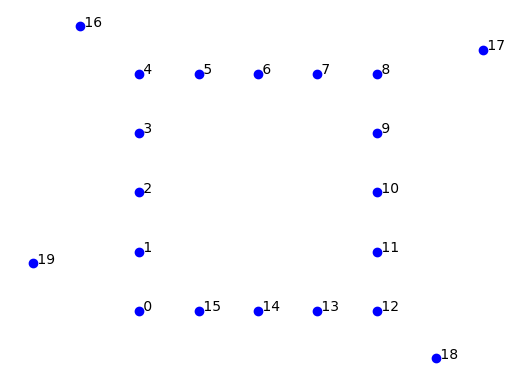

In [14]:
outliers_list = [(2, 2),  (2, 3),  (2, 4),  (2, 5),  (2, 6),  
                 (3, 6),  (4, 6),  (5, 6),  (6, 6),  
                 (6, 5),  (6, 4),  (6, 3),  (6, 2),  
                 (5, 2),  (4, 2),  (3, 2),  
                 (1, 6.8),  (7.8, 6.4),  (7, 1.2),  (0.2, 2.8)]
plot_labeled_lines(outliers_list)

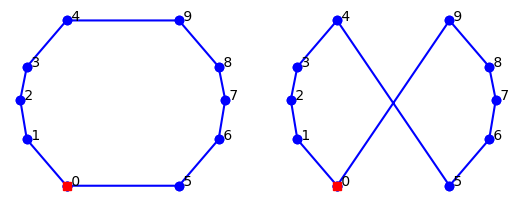

In [15]:
cross = [(9, 3),  (3, 10),  (2, 16),  (3, 21),  (9, 28), 
         (26, 3), (32, 10), (33, 16), (32, 21), (26, 28)]
fig,ax = plt.subplots(1,2)
plt.subplot(1,2,1)
tour = nn_tsp(cross)
plot_labeled_lines(cross, tour)
plt.subplot(1,2,2) # reverse segement 5-9 and we find that route is improved
plot_labeled_lines(cross, cross)

NameError: name 'reverse_segment_if_better' is not defined

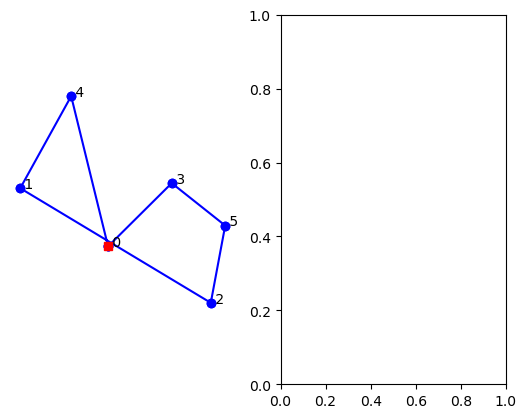

In [16]:
fig,ax = plt.subplots(1,2)
tour = nn_tsp(Cities(6))
plt.subplot(1,2,1)
plot_labeled_lines(Cities(6),tour)
plt.subplot(1,2,2)
tour = reverse_segment_if_better(tour, 1, 5)
plot_labeled_lines(Cities(6),altered_nn_tsp(Cities(6)))
#plot_labeled_lines(Cities(6),tour)

In [ ]:
def reverse_segment_if_better(tour, i, j):
    "If reversing tour[i:j] would make the tour shorter, then do it." 
    # Given tour [...A-B...C-D...], consider reversing B...C to get [...A-C...B-D...]
    A, B, C, D = tour[i-1], tour[i], tour[j-1], tour[j % len(tour)]
    # Are old edges (AB + CD) longer than new ones (AC + BD)? If so, reverse segment.
    if distance(A, B) + distance(C, D) > distance(A, C) + distance(B, D):
        tour[i:j] = reversed(tour[i:j])#slicing是前闭后开的,此处reverse的是i到j-1的元素
    return tour
    
def alter_tour(tour):
    'reverse segements if it makes improvements'
    original_length = tour_length(tour)
    for (start,end) in all_segments(len(tour)):
        reverse_segment_if_better(tour,start,end)
    if tour_length(tour) < original_length:
        return alter_tour(tour)
    return tour

def all_segments(n):
    "Return (start, end) pairs of indexes that form segments of tour of length N."
    segments = []
    for length in range(n,1,-1):
        for start in range(n-length+1):
            segments.append((start,start+length))
    return segments

def altered_nn_tsp(cities):
    return alter_tour(nn_tsp(cities))

def repeated_altered_nn_tsp(cities,n):
    return min([alter_tour(nn_tsp(cities,start)) for start in random_cities(cities,n)],key=tour_length)

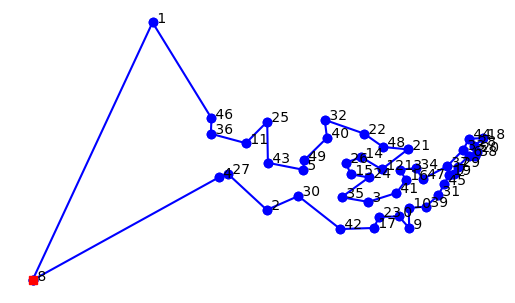

In [ ]:
data = pd.read_csv('example_data/us-state-capitals.csv')
usa_capitals = [(row['x'],row['y']) for index,row in data.iterrows()]
tour = repeated_altered_nn_tsp(usa_capitals,10)
plot_labeled_lines(usa_capitals,tour)

## Variable Neighbor Algorithm

In [13]:
init_tour = nn_tsp(global_cities)
#Swap two cities in the tour if it makes the tour shorter
def two_opt(tour):
    i,j = random.sample(range(len(tour)),k=2)
    original_length = tour_length(tour)
    new_tour = tour.copy()
    new_tour[i],new_tour[j] = new_tour[j],new_tour[i]
    # if tour_length(new_tour) < original_length:
    #     return new_tour
    return new_tour

def reverse(tour):
    i,j = random.sample(range(len(tour)),k=2)
    A,B,C,D = tour[i-1],tour[i],tour[j-1],tour[j%len(tour)]
    # if distance(A,B)+distance(C,D)>distance(A,C)+distance(B,D):
    #     tour[i:j] = reversed(tour[i:j])
    return tour

#Insert city i before city j
def insert(tour):
    i,j = random.sample(range(len(tour)),k=2)
    i,j = min(i,j),max(i,j)
    original_length = tour_length(tour)
    inserted_tour = tour[:i] + tour[i+1:j] + tour[i:i+1] + tour[j:]
    # if tour_length(inserted_tour) < original_length:
    #     return inserted_tour
    return inserted_tour

def local_search(tour,operator):
    new_tour = operator(tour)
    if tour_length(new_tour) < tour_length(tour):
        return new_tour
    return tour

def shaking(tour):
    k = random.choice([1,2,3])
    if k == 1:
        return two_opt(tour)
    elif k == 2:
        return reverse(tour)
    elif k == 3:
        return insert(tour)
    return tour

def VNS(cities,M,k):
    tour = nn_tsp(cities)
    operators = [two_opt,reverse,insert] * M
    #operators = random.sample(operator,k=len(operators))
    for i in range(3*M):
        if i%10 == 0 and i//10 < k:
            tour = shaking(tour)
        tour = local_search(tour,operators[i])
    return tour

4610.44376854724


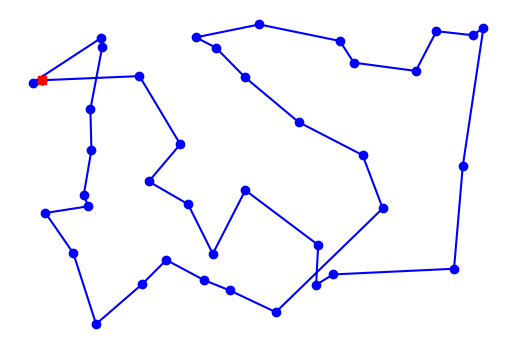

In [49]:
plot_tour(VNS(global_cities,10000,2))
print(tour_length(VNS(global_cities,1000,2)))

## Large Neighborhood Search Algorithm

In [66]:
def LNS(cities,iter,delete_num):
    init_tour = nn_tsp(cities)
    for i in range(iter):
        destroyed_tour,nodes = destroy(init_tour,delete_num)#To be defined
        new_tour = repair(destroyed_tour,nodes,init_tour)#To be defined
        if tour_length(new_tour) < tour_length(init_tour):
            init_tour = new_tour
    return init_tour

def destroy(tour, num):
    destroyed_nodes = []
    while len(destroyed_nodes) < num:
        n = random.randint(0,len(tour)-1)#generate destroy point
        while n in destroyed_nodes:
            n = random.randint(0,len(tour)-1)
        destroyed_nodes.append(n)
        destroyed_tour = [tour[i] for i in range(len(tour)) if i not in destroyed_nodes] ######To be modefied, how to get the destroyed tour, cannot directly use list.remove()
    return destroyed_tour,destroyed_nodes

def repair(destroyed_tour,destroyed_nodes,tour):
    for n in destroyed_nodes:
        distance = [0 for i in range(len(destroyed_tour))]
        for i in range(len(destroyed_tour)):
            inserted_tour = destroyed_tour[:i] + [tour[n]] + destroyed_tour[i:]
            distance.append(tour_length(inserted_tour))
        greedy_index = distance.index(min(distance))
        destroyed_tour = destroyed_tour[:greedy_index] + [tour[n]] + destroyed_tour[greedy_index:]
    return destroyed_tour

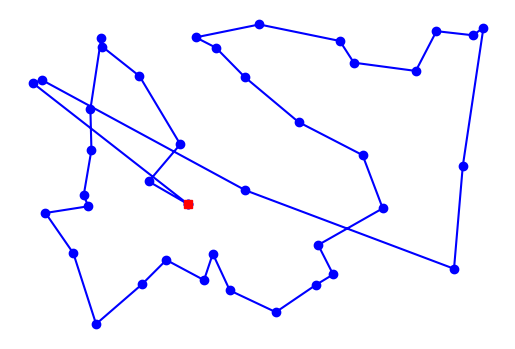

In [68]:
plot_tour(LNS(global_cities,10000,4))

# Greedy Algorithm

In [247]:
def greedy_tsp(cities):
    endpoints = {c: [c] for c in cities}
    for (A,B) in shortest_edges(cities):
        if A in endpoints and B in endpoints and endpoints[A] != endpoints[B]:
            new_segment = join_endpoints(endpoints,A,B)
            if len(new_segment) == len(cities):
                return new_segment

def shortest_edges(cities):
    #id() returns the memory address of the object
    edges = [(A,B) for A in cities for B in cities if A < B]
    return sorted(edges,key=lambda edge:distance(*edge))

def join_endpoints(endpoints,A,B):
    A_segment,B_segment = endpoints[A],endpoints[B]
    if A_segment[-1] is not A:
        A_segment.reverse()
    if B_segment[0] is not B:
        B_segment.reverse()
    A_segment.extend(B_segment)
    del endpoints[A],endpoints[B]
    endpoints[A_segment[0]] = endpoints[A_segment[-1]] = A_segment
    return A_segment

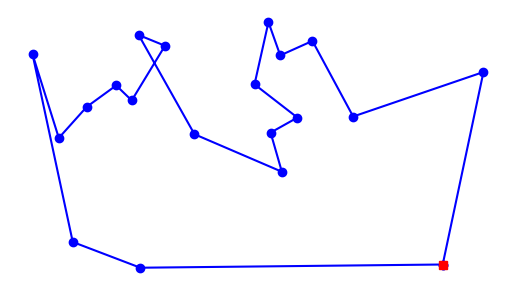

20 city tour with length 3237.3 in 3.734 secs for greedy_tsp


In [250]:
plot_tsp(greedy_tsp,global_cities)